# Generere boundary

1. ha alle veger/koordinater i COORDS
2. putter navn, punkt, og start/stopp inn her
    - sørger for at boundary ser fornuftig ut
    - boundary lagres til pickle
3. kjører .py scriptet som generer bilder av alle vegene/boundaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


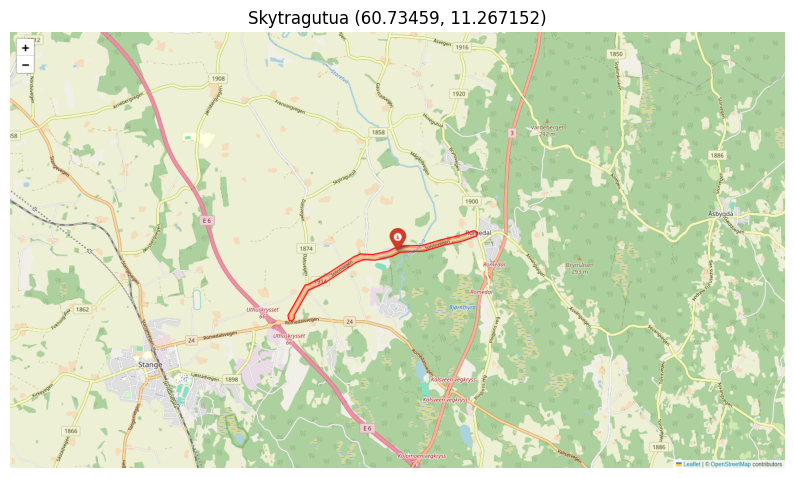

In [5]:
%load_ext autoreload
%autoreload 2

import openrouteservice
import os
from dotenv import load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import Point
from shapely.geometry import LineString
import contextily as cx
import pickle
from source import config
from source.config import INTERIM_DATA_DIR
from source.features_dir import estimated_registrations

# Load environment variables from the .env file
load_dotenv()

# Initialize OpenRouteService client
api_key = os.getenv('ORS_API_KEY')
client = openrouteservice.Client(key=api_key)

# Coordinates for the start and end points (from the map markers)
road = 'Skytragutua'
lat, lon = 60.734590, 11.267152
start_lat, start_lon = 60.724526465449955, 11.234912631070497
end_lat, end_lon = 60.73700587308119, 11.290405954357002
point = Point(lat, lon)
start, end = (start_lon, start_lat), (end_lon, end_lat)
# start, end = (start_lat, start_lon), (end_lat, end_lon)

route = client.directions(
    coordinates=[start, end],
    format='geojson'
)

road_coords = route['features'][0]['geometry']['coordinates']
line = LineString(road_coords)

gdf = gpd.GeoDataFrame(geometry=[line], crs='EPSG:4326')
gdf_mercator = gdf.to_crs(epsg=3857)

buffer = gdf_mercator.geometry.buffer(100)
gdf_buffer = gpd.GeoDataFrame(geometry=buffer, crs='EPSG:3857')

# scirmish = gpd.GeoDataFrame(geometry=[Point(lon - 0.02, lat - 0.02), Point(lon - 0.02, lat + 0.02), Point(lon + 0.02, lat - 0.02), Point(lon + 0.02, lat + 0.02)], crs='EPSG:4326').to_crs(epsg=3857)


# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_buffer.plot(ax=ax, color='orange', alpha=0.5)
# gdf_mercator.plot(ax=ax, color='blue', linewidth=2)
# scirmish.plot(ax=ax, color="green", alpha=0, label="Buffer Area")
# cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap, crs='EPSG:3857')
# ax.set_title("Route and Buffer Zone")
# ax.legend()
# plt.show()

# Save the GeoDataFrame to a pickle file
pickle_path = INTERIM_DATA_DIR / f'estimated_registrations' / estimated_registrations.SUBPATH

os.makedirs(pickle_path, exist_ok=True)

with open(pickle_path / f'{road}_boundary.pkl', 'wb') as f:
    pickle.dump(gdf_buffer, f)

estimated_registrations.main(
    road_coordinates = {road: (lat, lon)}, 
    pickle_path = pickle_path, 
    figures_dir = config.ESTIMATED_REGISTRATIONS_74T_DIR / estimated_registrations.SUBPATH / 'figures'
)


# Plotting av boundary på kartet (kjører heller med .py scriptet)

KeyboardInterrupt: 

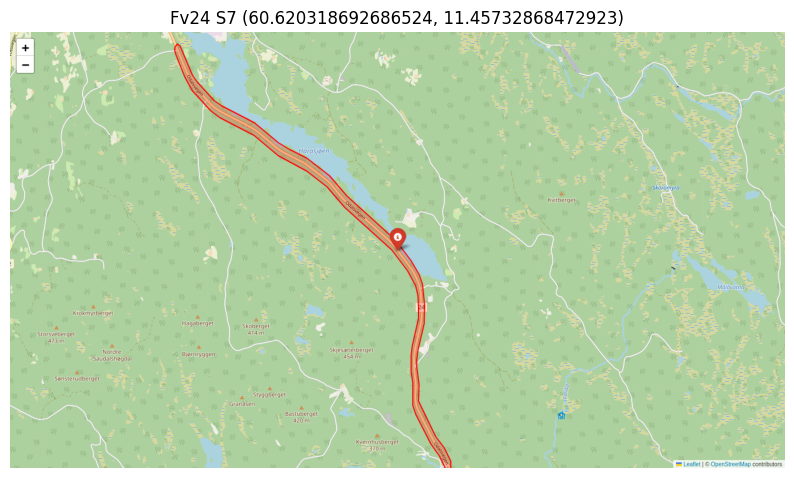

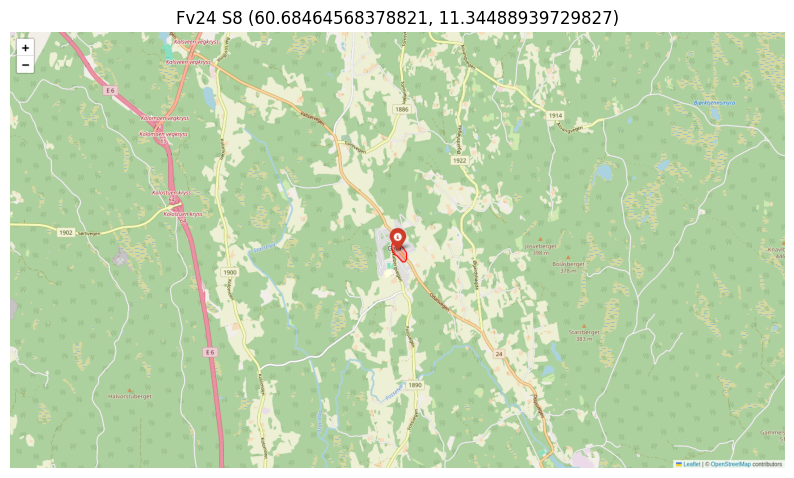

In [79]:
import pickle
import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon
import math
from source.features_dir import estimated_registrations
from source.config import INTERIM_DATA_DIR
from IPython.display import HTML, display
from PIL import Image
from io import BytesIO

def meters_to_degrees(meters, lat):
    """
    Convert distance in meters to degrees for latitude and longitude. Roughly, close enough.
    """
    lat_degrees = meters / 111320
    lon_degrees = meters / (111320 * math.cos(math.radians(lat)))
    return lat_degrees, lon_degrees

# Retrieve coordinate keys and pickle files
keys = list(estimated_registrations.COORDINATE_POINTS_ROADS.keys())
pickle_files = [INTERIM_DATA_DIR / f"estimated_registrations/{key}_boundary.pkl" for key in keys]

# Loop through keys and pickle files
for key, pickle_file in zip(keys, pickle_files): 
    # Get coordinates and buffer dimensions
    lat, lon = estimated_registrations.COORDINATE_POINTS_ROADS[key]
    lat_buf, lon_buf = meters_to_degrees(
        estimated_registrations.THRESHOLD_METER_REGISTRATION_RADIUS_FROM_COORDINATE_POINT, lat
    )

    # Create the Folium map centered on the coordinates
    m = folium.Map(location=[lat, lon], zoom_start=13)

    # Add the buffer area as a polygon
    buffer_coords = [
        [lat - lat_buf, lon - lon_buf],
        [lat - lat_buf, lon + lon_buf],
        [lat + lat_buf, lon + lon_buf],
        [lat + lat_buf, lon - lon_buf],
    ]
    folium.Polygon(
        locations=buffer_coords,
        color="none",
        fill=False,
        tooltip="Buffer Area"
    ).add_to(m)

    # Load the boundary from the pickle file
    with open(pickle_file, "rb") as f:
        boundary = pickle.load(f)

    # If the boundary is a GeoDataFrame, use it directly, otherwise create one
    if isinstance(boundary, gpd.GeoDataFrame):
        boundary_gdf = boundary
    else:
        boundary_gdf = gpd.GeoDataFrame(geometry=[boundary], crs="EPSG:4326")

    # Add the boundary as a GeoJSON layer to the map
    folium.GeoJson(
        boundary_gdf,
        name="Boundary",
        style_function=lambda x: {"color": "red", "weight": 2, "fillOpacity": 0.2},
    ).add_to(m)

    # Add a marker for the center point
    folium.Marker(
        location=[lat, lon],
        popup=f"<b>Key:</b> {key}",
        tooltip="Center Point",
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(m)

    img_data = m._to_png(10)  # 5 for higher DPI

    # Open the image data using Pillow
    img = Image.open(BytesIO(img_data))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')
    ax.set_title(f'{key} ({lat}, {lon})')
    ax.imshow(img)
    plt.savefig(f"{key}_boundary.png", format="png", bbox_inches='tight', pad_inches=0, dpi=1000)

